# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [2]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 270 kB 22.3 MB/s            
     |████████████████████████████████| 83 kB 185 kB/s             


In [3]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
import os

In [4]:
# session and role setup
role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [5]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2021-12-29 19:35:55--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 3.5.162.102
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|3.5.162.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  36.8MB/s    in 40s     

2021-12-29 19:36:37 (27.2 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.Affenp

In [13]:
# Upload image data to s3

bucket = sagemaker_session.default_bucket()
data_dir = "dogImages"
prefix = "dogImages"

input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)

In [108]:
objects = boto3.resource('s3').Bucket(bucket).objects.all()
breeds = set()
unique = [breeds.add(obj.key.split('/')[2].split('.')[1]) for obj in objects if obj.key.split('/')[1] == 'test']
all_breeds = list(breeds)

In [15]:
# s3 data verification
objects = [obj.key for obj in boto3.resource('s3').Bucket(bucket).objects.all()]

assert len(objects) != 0, f's3 bucket: {bucket} empty'
print('Bucket not empty!')

Bucket not empty!


## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [7]:
#TODO: Declare your HP ranges, metrics etc.
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batchsize": CategoricalParameter([32, 64, 128]),
}

In [8]:
#TODO: Create estimators for your HPs
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version="py36",
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.g4dn.xlarge"
)

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [9]:
# TODO: Fit your HP Tuner
s3_train_key = "dogImages"

s3_train_data = "s3://{}/{}/".format(bucket, "dogImages")
s3_output_dir = "s3://{}/{}/".format(bucket, "output")
s3_model_dir = "s3://{}/{}/".format(bucket, "model")

os.environ['SM_CHANNEL_TRAINING']= s3_train_data
os.environ['SM_MODEL_DIR']= s3_model_dir
os.environ['SM_OUTPUT_DATA_DIR']= s3_output_dir

tuner.fit(
    {"training": s3_train_data})

# tuner.fit(wait=True)

In [18]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2021-12-27 17:31:28 Starting - Preparing the instances for training
2021-12-27 17:31:28 Downloading - Downloading input data
2021-12-27 17:31:28 Training - Training image download completed. Training in progress.
2021-12-27 17:31:28 Uploading - Uploading generated training model
2021-12-27 17:31:28 Completed - Training job completed


{'_tuning_objective_metric': '"average test loss"',
 'batchsize': '"32"',
 'lr': '0.02661978668421114',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2021-12-27-16-51-51-049"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-366814688956/pytorch-training-2021-12-27-16-51-51-049/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [10]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)
debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

In [84]:
s3_train_key = "dogImages"

s3_train_data = "s3://{}/{}/".format(bucket, "dogImages")
s3_output_dir = "s3://{}/{}/".format(bucket, "output")
s3_model_dir = "s3://{}/{}/".format(bucket, "model")


os.environ['SM_CHANNEL_TRAINING']= s3_train_data
os.environ['SM_MODEL_DIR']= s3_model_dir
os.environ['SM_OUTPUT_DATA_DIR']= s3_output_dir

In [81]:
os.environ['SM_CHANNEL_TRAINING']

's3://sagemaker-us-east-1-051127491882/dogImages/'

In [82]:
os.environ['SM_MODEL_DIR']

's3://sagemaker-us-east-1-051127491882/model/'

In [85]:
os.environ['SM_OUTPUT_DATA_DIR']

's3://sagemaker-us-east-1-051127491882/output/'

In [113]:
# TODO: Create and fit an estimator

hyperparameters = {"batchsize": "32", "lr": "0.001"}

estimator = PyTorch(
    role=role,
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    entry_point="train_model.py",
    framework_version="1.8",
    py_version="py36",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)
estimator.fit({"training": s3_train_data}, wait=False)

In [15]:
# TODO: Plot a debugging output.
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

print(f"Training jobname: {job_name}")
# print(f"Region: {region}")

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

print(trial.tensor_names())
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

Training jobname: pytorch-training-2021-12-29-20-01-09-537
[2021-12-29 21:01:03.791 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:63 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-12-29 21:01:03.825 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:63 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-051127491882/pytorch-training-2021-12-29-20-01-09-537/debug-output
[2021-12-29 21:01:04.991 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:63 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2021-12-29 21:01:06.014 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:63 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/Inception3_fc.0.bias', 'gradient/Inception3_fc.0.weight', 'gradient/Inception3_fc.2.bias', 'gradient/Inception3_fc.2.weight']
1
12


In [16]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


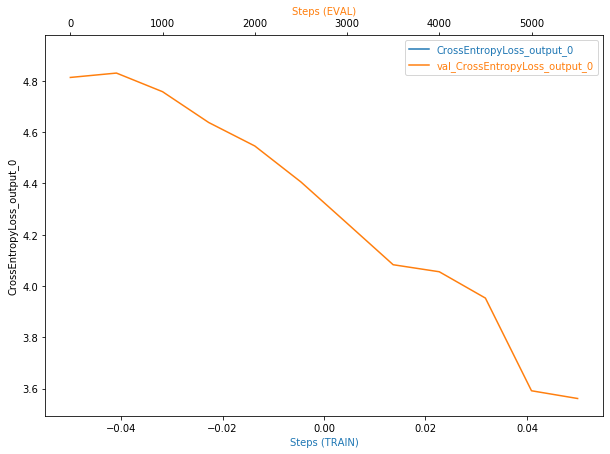

In [18]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [19]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-051127491882/pytorch-training-2021-12-29-20-01-09-537/rule-output


In [20]:
! aws s3 ls {rule_output_path} --recursive

2021-12-29 21:00:01     448423 pytorch-training-2021-12-29-20-01-09-537/rule-output/ProfilerReport/profiler-output/profiler-report.html
2021-12-29 21:00:00     309300 pytorch-training-2021-12-29-20-01-09-537/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2021-12-29 20:59:55        564 pytorch-training-2021-12-29-20-01-09-537/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2021-12-29 20:59:55      90660 pytorch-training-2021-12-29-20-01-09-537/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2021-12-29 20:59:55       2063 pytorch-training-2021-12-29-20-01-09-537/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2021-12-29 20:59:55        329 pytorch-training-2021-12-29-20-01-09-537/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2021-12-29 20:59:55       6262 pytorch-training-2021-12-29-20-01-09-537/rule-output/ProfilerReport/profiler-output/profiler-re

In [21]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-051127491882/pytorch-training-2021-12-29-20-01-09-537/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-051127491882/pytorch-training-2021-12-29-20-01-09-537/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-051127491882/pytorch-training-2021-12-29-20-01-09-537/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-051127491882/pytorch-training-2021-12-29-20-01-09-537/rule-output/ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json to ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json
download: s3://sagemaker-us-east-1-051127491882/pytorc

In [22]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [23]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")


## Model Deploying

In [54]:
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

In [55]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

In [56]:
class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [114]:
model_location=estimator.model_data
model_location

's3://sagemaker-us-east-1-051127491882/pytorch-training-2021-12-30-02-00-09-818/output/model.tar.gz'

In [115]:
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='inference.py',py_version='py3',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor)

In [ ]:
# TODO: Deploy your model to an endpoint
predictor=pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge')
predictor

---

In [72]:
import requests
#request_dict={ "url": "https://cdn1-www.cattime.com/assets/uploads/2011/12/file_2744_british-shorthair-460x290-460x290.jpg" }
request_dict={ "url": "https://sagemaker-us-east-1-051127491882.s3.amazonaws.com/dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg" }

img_bytes = requests.get(request_dict['url']).content
type(img_bytes)

bytes

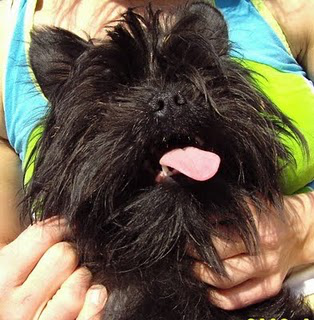

In [92]:
from PIL import Image
import io
Image.open(io.BytesIO(img_bytes))

In [93]:
response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})

In [94]:
import json
response2=predictor.predict(json.dumps(request_dict), initial_args={"ContentType": "application/json"})

In [95]:
response2[0]

[0.08883616328239441,
 0.07958792895078659,
 0.10082157701253891,
 0.1528022587299347,
 0.053806185722351074,
 0.018666094169020653,
 -0.062134772539138794,
 0.043119095265865326,
 -0.16498498618602753,
 -0.021684076637029648,
 -0.10836507380008698,
 0.169794499874115,
 -0.1288110315799713,
 0.030138324946165085,
 0.17127591371536255,
 -0.014697287231683731,
 -0.00405709445476532,
 0.04626557230949402,
 -0.061949096620082855,
 0.1040014773607254,
 -0.0033268537372350693,
 -0.13393348455429077,
 -0.05104196071624756,
 0.03764767572283745,
 -0.05050273239612579,
 -0.16094307601451874,
 -0.030101526528596878,
 -0.2828122079372406,
 0.024784676730632782,
 -0.08374026417732239,
 0.1862701177597046,
 0.15224507451057434,
 0.11224071681499481,
 0.11086209118366241,
 -0.004273869097232819,
 -0.06944426149129868,
 -0.018970921635627747,
 0.06141762435436249,
 0.07597322016954422,
 0.008403566665947437,
 0.21417146921157837,
 -0.2274986207485199,
 -0.07305411994457245,
 0.14955416321754456,
 0.0

In [112]:
all_breeds[np.argmax(response, 1)[0]]

'Bouvier_des_flandres'

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()